In [1]:
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import matplotlib.pyplot as plt
from intensity_normalization.normalize.zscore import ZScoreNormalize

path_to_testfile = Path("/Users/LennartPhilipp/Desktop/testing_data/raw_data/sub-01009590/anat/sub-01009590_FLAIR.nii.gz")





In [2]:
def fill_holes(
    binary_image: sitk.Image,
    radius: int = 3,
) -> sitk.Image:
    """
    Fills holes in binary segmentation

    Keyword Arguments:
    - binary_image: sitk.Image = binary brain segmentation
    - radius: int = kernel radius

    Returns:
    - closed_image: sitk.Image = binary brain segmentation with holes filled
    """

    closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
    closing_filter.SetKernelRadius(radius)
    closed_image = closing_filter.Execute(binary_image)

    return closed_image


def binary_segment_brain(
    image: sitk.Image,
) -> sitk.Image:
    """
    Returns binary segmentation of brain from brain-extracted scan via otsu thresholding

    Keyword Arguments:
    - image: sitk.Image = brain-extracted scan

    Returns:
    - sitk.Image = binary segmentation of brain scan with filled holes
    """

    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(0)
    otsu_filter.SetOutsideValue(1)
    binary_mask = otsu_filter.Execute(image)

    return fill_holes(binary_mask)

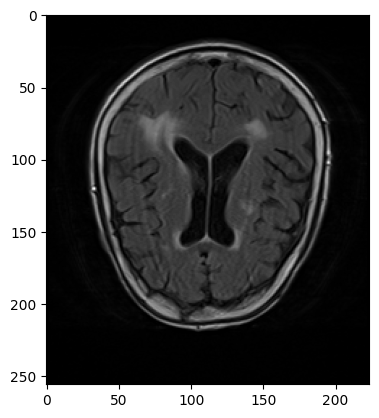

In [3]:
# load image
og_image = sitk.ReadImage(str(path_to_testfile))
# convert to numpy array
img_array = sitk.GetArrayFromImage(og_image)
# show image
plt.imshow(img_array[14, :, :], cmap="gray")

Text(0.5, 1.0, 'Difference')

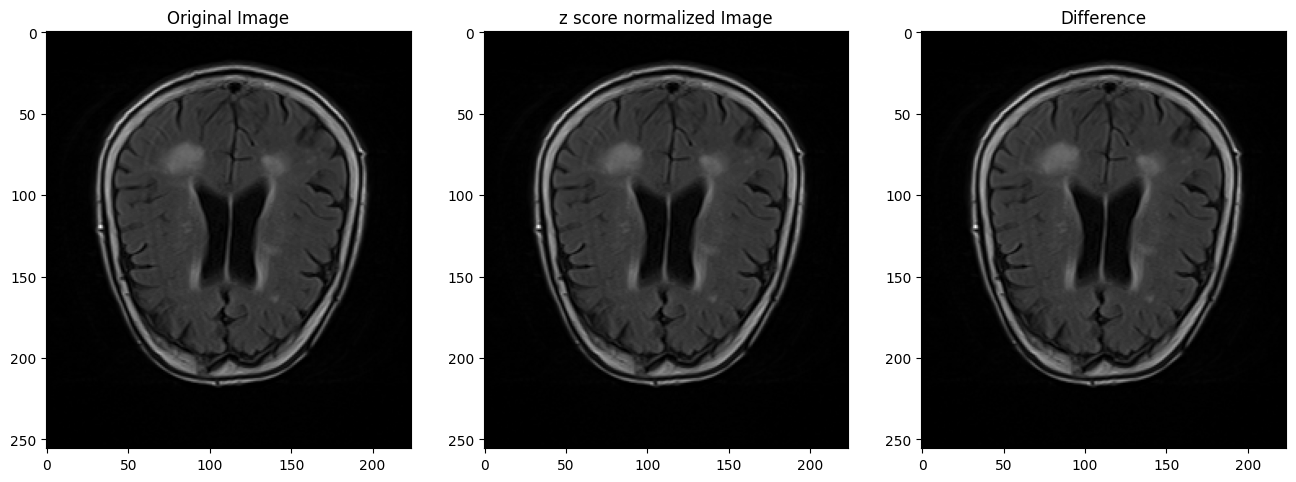

In [4]:
# z score normalize image
normalizer = ZScoreNormalize()
image_normalized_array = normalizer(sitk.GetArrayFromImage(og_image))
image_normalized = sitk.GetImageFromArray(image_normalized_array)
image_normalized.CopyInformation(og_image)


plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.imshow(img_array[15, :, :], cmap="gray")
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(sitk.GetArrayFromImage(image_normalized)[15, :, :], cmap="gray")
plt.title("z score normalized Image")

plt.subplot(1, 3, 3)
plt.imshow(img_array[15, :, :] - sitk.GetArrayFromImage(image_normalized)[15, :, :], cmap="gray")
plt.title("Difference")

# plt.show()
# plt.imshow(image_normalized[14, :, :], cmap="gray")

In [5]:
mask_image = binary_segment_brain(image_normalized)
corrector = sitk.N4BiasFieldCorrectionImageFilter()
image_corrected = corrector.Execute(image_normalized)

mask_filter = sitk.MaskImageFilter()
mask_filter.SetOutsideValue(0)
image_corrected_masked = mask_filter.Execute(image_corrected, mask_image)

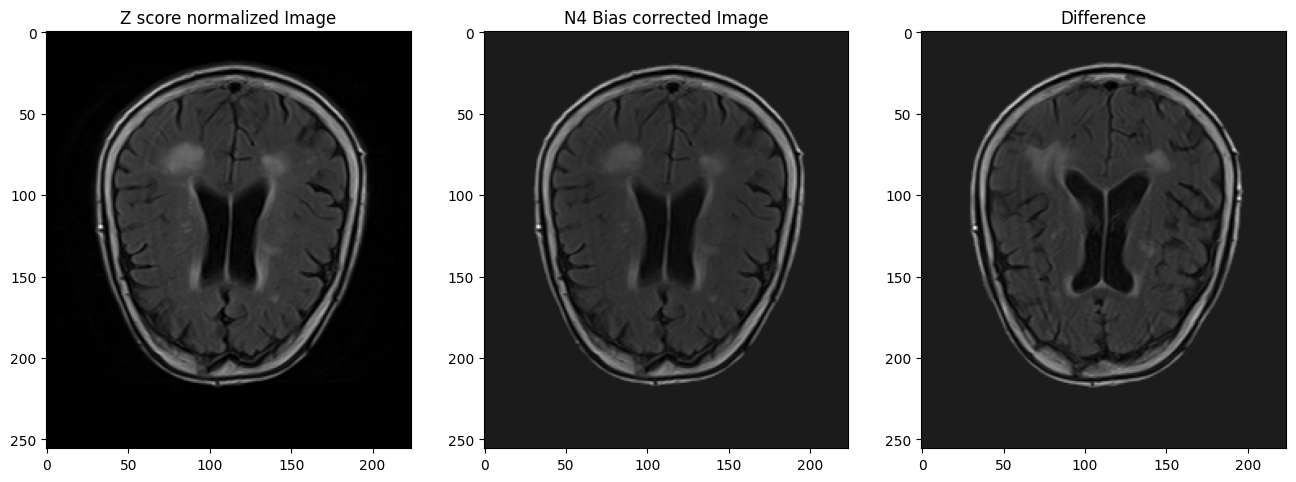

In [7]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.imshow(sitk.GetArrayFromImage(image_normalized)[15, :, :], cmap="gray")
plt.title("Z score normalized Image")

plt.subplot(1, 3, 2)
plt.imshow(sitk.GetArrayFromImage(image_corrected_masked)[15, :, :], cmap="gray")
plt.title("N4 Bias corrected Image")

plt.subplot(1, 3, 3)
plt.imshow(sitk.GetArrayFromImage(image_normalized)[15, :, :] - sitk.GetArrayFromImage(image_corrected_masked)[15, :, :], cmap="gray")
plt.title("Difference")

# show difference between images in plot

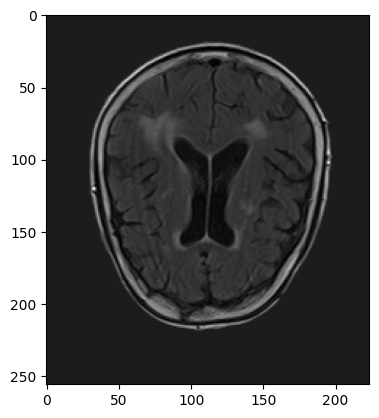

In [8]:
plt.imshow(sitk.GetArrayFromImage(image_corrected_masked)[14, :, :], cmap="gray")